# Churn Prediction

In [439]:
#Required Packages:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from collections import Counter
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

### Loading Data and cleaning data:
Following intial assumptions where made for data cleaning and creating the predictive features:
<br> 1- Customer_id does not contain any predictive information
<br> 2- 'channel', 'geo', 'start_date', 'end_date', 'carrier', and 'profession' are categorical features used for prediction
<br> 3- We are not using the cancelation reason as predditive feature. Although, it can be a good feature to for exploratory analysis, it cannot be a modeling attribute. Since we don't have it for active policies.                                      <br>4- The model is set up as a classification. The target value "y" can take values from 0-11 indicating the policy has ended in which month and value 12 showing that the policy is active.  

In [329]:
df = pd.read_csv('data_challenge_churn.csv', parse_dates = ['start_date','end_date'])
predictive_features = ['channel', 'geo', 'carrier', 'profession']
X = df[predictive_features]

X.fillna('unk', inplace = True)

df['diff_date'] = (df['end_date'] - df['start_date'])/np.timedelta64(1,'M')

one_year_diff = df.diff_date.iloc[0]
boo = df.diff_date == one_year_diff
df.diff_date[boo] = 12
y = np.floor(df.diff_date)

print(type(df.start_date[1]))
X.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,channel,geo,carrier,profession
0,affiliation,CA,2,1000
1,affiliation,NY,2,1000
2,support,TX,7,5009
3,sem,OH,3,3000
4,email,MO,7,100001


### Exploratory Data Analysis and Visulization and:
Below is the histogram of the target variable y. This shows that we are dealing with an imbalanced data-set as most of the class "12" has clear maority. This means that the majority of the policy holders remains in the policy after one year.


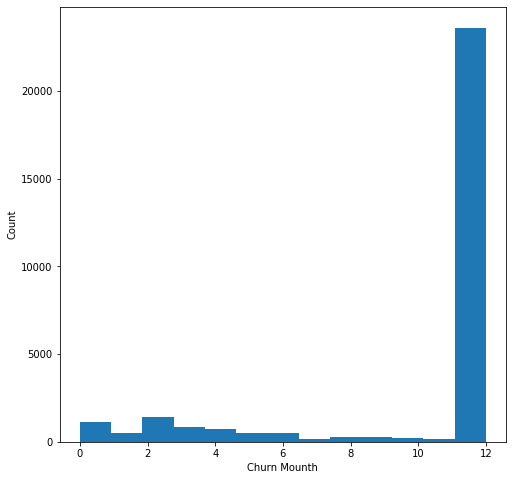

In [438]:
figure, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Churn Mounth")  #x = 12 --> churn didn't occure
ax.set_ylabel("Count")
ax.hist(y, bins = 13);
figure.savefig("y_hist", dpi=300)

#### Since attribute is a categorical variable, it is important to know how many category each feature has. Following code shows this.

In [331]:
for fea in X.keys():
    print('Number of categories in feature ' + fea + ' = {:.0f}'.format(len(Counter(X[fea]))))
    

Number of categories in feature channel = 17
Number of categories in feature geo = 51
Number of categories in feature carrier = 6
Number of categories in feature profession = 53


#### Following figures show the predictive features with respective to the target value. For the sake of visualization, the target value is shown only with two classes. For same reason, category profession is shown with numbers 1 to 50. 

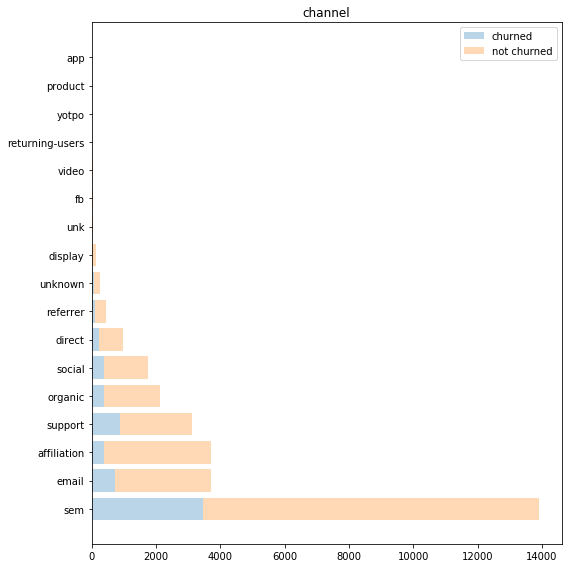

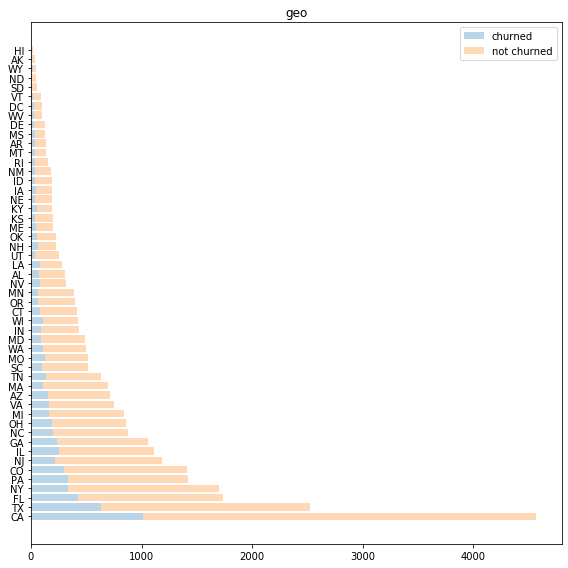

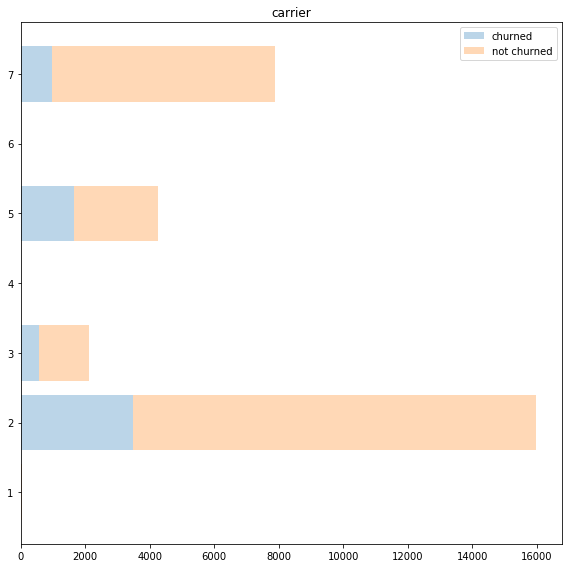

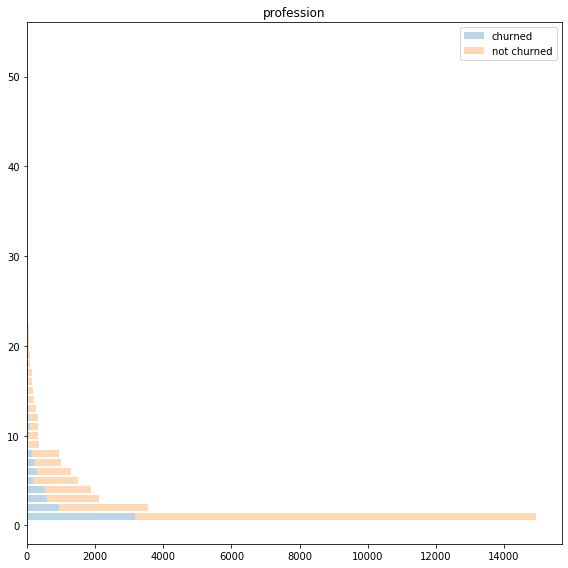

In [432]:
for val in range(4):
    figure, ax = plt.subplots(1,1)
    not_churned = []
    churned = []
    cat_list = X[X.keys()[val]].value_counts().keys()

    for cat in cat_list:
        comp = X[X.keys()[val]] == cat
        A = np.sum(y[comp]==12)
        B = np.sum(comp) 
        churned.append(A)                           
        not_churned.append(B-A)
        
    if val==3: 
        cat_list = [i for i in range(1,54)]
    
    p1 = plt.barh(cat_list, not_churned, align='center', alpha=0.3)
    p2 = plt.barh(cat_list, churned, left = not_churned, align='center', alpha=0.3) 
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    plt.legend((p1[0],p2[0]),('churned','not churned'))
    plt.title(X.keys()[val])
    plt.tight_layout()
    fig.savefig(str(val), dpi=300)
    

In [346]:
class ClassificationModel(object): 
    def __init__(self, X_num, X_cat, class_num):
        global Pipeline, GridSearchCV
        from sklearn.pipeline import Pipeline
        from sklearn.model_selection import GridSearchCV
        
        self.GridSearchCV = GridSearchCV
        self.Pipeline = Pipeline
        self.X_num = X_num
        self.X_cat = X_cat
        self.class_num = class_num
         
    def preproccess(self):
        from sklearn.preprocessing import OneHotEncoder, StandardScaler
        from sklearn.compose import ColumnTransformer
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_one_hot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.X_num),
                ('cat_onehot', categorical_one_hot_transformer, self.X_cat)])
        
        return self.preprocessor
        
    def LogisticRegressionBuilder(self,param_grid, scoring):
        from sklearn.linear_model import LogisticRegression
        
        lr_pipe = Pipeline(steps=[('preprocessor', self.preproccess()),
                              ('classifier', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])
        
        lr_grid = GridSearchCV(lr_pipe, param_grid, cv=5, iid=False, scoring=scoring, n_jobs=-1)
        
        return lr_grid
    
    def RadndomForrestBuilder(self,param_grid,scoring):
        from sklearn.ensemble import RandomForestClassifier

        rf_pipe = Pipeline(steps=[('preprocessor', self.preprocessor),
                     ('classifier', RandomForestClassifier(max_features = 'auto'))])

        grid_rf = GridSearchCV(rf_pipe, param_grid, cv=5, scoring= scoring
                               , n_jobs=-1)

        return grid_rf

In [436]:
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=4)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(30313, 4)
(22734, 4)
(7579, 4)


### Since the dataset has class imbalance, the training data is oversampled 

In [348]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
X_train_oversample = pd.DataFrame(X_train_oversample, columns = X.keys())

In [444]:
class_names = ['class_'+str(i) for i in range(1,14)]
Counter(y_train_oversample)

Counter({12.0: 17669,
         2.0: 17669,
         11.0: 17669,
         0.0: 17669,
         1.0: 17669,
         4.0: 17669,
         3.0: 17669,
         8.0: 17669,
         5.0: 17669,
         6.0: 17669,
         10.0: 17669,
         9.0: 17669,
         7.0: 17669})

#### Two Classification Models (Logistic Regression and RandomForrest), are tested and optimized for their hyperparameters.The trained classifiers are tested with the set aside test data. The test accuracy for logistic regression model on test set is 0.21 and the accuracy of the RandomForrest model for the test set is 0.28.  

## Logistic Regression Builder

In [351]:
X_num = []
X_cat = X.keys()

param_grid = {
          'classifier__C': [.01, .1, 1, 10, 100, 1000],       
}

CM = ClassificationModel(X_num, X_cat, 13);
grid_lr = CM.LogisticRegressionBuilder(param_grid, 'accuracy');
grid_lr.fit(X_train_oversample,y_train_oversample)
print ("Best cross-validation Logistic {:.2f}".format(grid_lr.best_score_))
print ("Best parameters:{}".format(grid_lr.best_params_))

Best cross-validation Logistic 0.21
Best parameters:{'classifier__C': 0.1}


### Classification Summary for Logistic Regression 

In [457]:
print ("Test Accuracy for LR model = {:.4f}".format(grid_lr.score(X_test,y_test)))
print(classification_report(y_test, grid_lr.predict(X_test), target_names=class_names))
Counter(grid_lr.predict(X_train))

Test Accuracy for LR model = 0.2188
              precision    recall  f1-score   support

     class_1       0.07      0.24      0.11       287
     class_2       0.02      0.08      0.03       110
     class_3       0.07      0.10      0.08       354
     class_4       0.02      0.01      0.02       206
     class_5       0.04      0.02      0.03       175
     class_6       0.01      0.03      0.02       123
     class_7       0.03      0.03      0.03       120
     class_8       0.01      0.10      0.02        41
     class_9       0.01      0.04      0.02        71
    class_10       0.02      0.16      0.03        61
    class_11       0.01      0.16      0.02        45
    class_12       0.01      0.48      0.02        31
    class_13       0.90      0.25      0.39      5955

    accuracy                           0.22      7579
   macro avg       0.09      0.13      0.06      7579
weighted avg       0.72      0.22      0.32      7579



Counter({9.0: 1639,
         12.0: 4985,
         3.0: 577,
         0.0: 2630,
         10.0: 2078,
         2.0: 1605,
         11.0: 3930,
         1.0: 1695,
         5.0: 884,
         4.0: 314,
         6.0: 472,
         8.0: 937,
         7.0: 988})

##  RandomForrest Builder

In [353]:
param_grid = {'classifier__max_depth': [5, 10, 20, 40, 80],
               'classifier__max_features': [10],
                'classifier__n_estimators': [100],
             }
grid_rf = CM.RadndomForrestBuilder(param_grid, scoring = 'accuracy')

grid_rf.fit(X_train_oversample,y_train_oversample)
print ("Best cross-validation score Random Forrest {:.2f}".format(grid_rf.best_score_))
print ("Best parameters:{}".format(grid_rf.best_params_))

Best cross-validation score Random Forrest 0.44
Best parameters:{'classifier__max_depth': 80, 'classifier__max_features': 10, 'classifier__n_estimators': 100}


### Classification Summary for RandomForrest

In [459]:
print ("Test Accuracy for LR model = {:.4f}".format(grid_rf.score(X_test,y_test)))
print(classification_report(y_test, grid_rf.predict(X_test), target_names=class_names))
Counter(grid_rf.predict(X_train))
a = classification_report(y_test, grid_rf.predict(X_test), target_names=class_names)

Test Accuracy for LR model = 0.2826
              precision    recall  f1-score   support

     class_1       0.10      0.18      0.13       287
     class_2       0.01      0.03      0.01       110
     class_3       0.07      0.08      0.08       354
     class_4       0.03      0.06      0.04       206
     class_5       0.06      0.09      0.07       175
     class_6       0.02      0.05      0.02       123
     class_7       0.04      0.12      0.05       120
     class_8       0.01      0.12      0.03        41
     class_9       0.02      0.10      0.03        71
    class_10       0.02      0.15      0.03        61
    class_11       0.01      0.18      0.03        45
    class_12       0.01      0.26      0.02        31
    class_13       0.86      0.33      0.48      5955

    accuracy                           0.28      7579
   macro avg       0.10      0.13      0.08      7579
weighted avg       0.69      0.28      0.39      7579



### RMSE of predicted months

In [466]:
y_pred = grid_lr.predict(X_test)
rmse = (sum((y_pred-y_test.values)**2))**0.5
print ("Root Mean Square Error Logistic Regression:{}".format(rmse)) 

Root Mean Square Error Logistic Regression:545.3851849839707


In [467]:
y_pred = grid_rf.predict(X_test)
rmse = (sum((y_pred-y_test.values)**2))**0.5
print ("Root Mean Square Error RandomForrest:{}".format(rmse)) 

Root Mean Square Error RandomForrest:513.7197679669335


### Predicted probabilities for the 13 classes using the two models

In [416]:
pd.DataFrame(grid_lr.predict_proba(X_test)[0:10], columns = range(1,14))

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.022471,0.030067,0.035862,0.052399,0.053897,0.071793,0.087370,0.115687,0.170110,0.167395,0.073379,0.036943,0.082627
1,0.132735,0.081857,0.282117,0.198163,0.034282,0.010317,0.001958,0.000275,0.000113,0.000117,0.000086,0.000277,0.257700
2,0.033268,0.045236,0.056327,0.059353,0.094452,0.072004,0.119568,0.099473,0.085762,0.055635,0.159721,0.071442,0.047758
3,0.015507,0.019470,0.053101,0.063592,0.048103,0.051237,0.069156,0.130973,0.086429,0.103722,0.163129,0.148505,0.047077
4,0.106415,0.125793,0.247300,0.181985,0.054487,0.064002,0.006080,0.000324,0.000037,0.000006,0.000087,0.000019,0.213466
5,0.091348,0.153794,0.058222,0.051538,0.084176,0.064086,0.110038,0.003671,0.097408,0.037104,0.089077,0.106984,0.052554
6,0.107188,0.238487,0.058670,0.059308,0.065452,0.038090,0.036625,0.000469,0.012119,0.019431,0.300427,0.020675,0.043060
7,0.115324,0.094027,0.129359,0.142889,0.040662,0.007814,0.037790,0.001379,0.322074,0.045763,0.030003,0.009653,0.023261
8,0.070612,0.097106,0.062800,0.041972,0.061154,0.072261,0.103411,0.129311,0.060174,0.049408,0.167031,0.038214,0.046545
9,0.120286,0.044166,0.027507,0.045093,0.071883,0.149692,0.036239,0.087808,0.209676,0.053181,0.033675,0.035939,0.084854


In [417]:
pd.DataFrame(grid_rf.predict_proba(X_test)[0:10], columns = range(1,14))

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.000000,0.137726,0.000000,0.000000,0.000000,0.000000,0.453968,0.385536,0.000000,0.000000,0.000000,0.022770
1,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.960000
2,0.010259,0.030683,0.059249,0.059135,0.113348,0.056070,0.105629,0.112590,0.082334,0.064770,0.191530,0.069069,0.045333
3,0.023025,0.037138,0.054058,0.039446,0.055324,0.016693,0.078442,0.282948,0.061116,0.099237,0.203837,0.000000,0.048738
4,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.061847,0.273609,0.000000,0.137478,0.067112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437533,0.022420
6,0.150000,0.029630,0.240000,0.003056,0.006944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570370
7,0.118394,0.000000,0.187062,0.000000,0.000000,0.000000,0.000000,0.000000,0.687348,0.000000,0.000000,0.000000,0.007196
8,0.103549,0.000000,0.265916,0.000000,0.000000,0.000000,0.000000,0.566094,0.000000,0.000000,0.000000,0.000000,0.064440
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965997,0.000000,0.000000,0.000000,0.034003
